In [1]:
from ddganAE.models import AAE, AAE_combined_loss, CAE, SVDAE
from ddganAE.architectures import *
from ddganAE.preprocessing import convert_2d
from ddganAE.utils import calc_pod
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# POD

This can be used to check against, we try to find models that perform better than POD. Let's use 10 POD components, i.e. 10 latent space dimensions.

In [59]:
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

# Data normalization
layer = preprocessing.Normalization(axis=None)
layer.adapt(snapshots_grids)

snapshots_grids = layer(snapshots_grids).numpy()

coeffs, R = calc_pod(snapshots_grids, nPOD=10)

In [60]:
# Reconstruct the first subgrid
recon = R @ coeffs[0]
print(recon, '\n',
      snapshots_grids[0, :, :])

np.allclose(recon, snapshots_grids[0, :, :], atol=1e-1)

[[-0.06574968  0.889425    0.88533004 ...  0.87480204  0.87580177
   0.87668235]
 [-0.06609004  0.90028732  0.89612372 ...  0.87883499  0.88167603
   0.88347498]
 [-0.06642842  0.91079298  0.9066454  ...  0.88245219  0.88744083
   0.89054423]
 ...
 [ 0.00203796 -0.91469858 -0.9098966  ... -0.84175103 -0.84852721
  -0.85643904]
 [ 0.01400781 -0.90751887 -0.90274946 ... -0.86341723 -0.86687382
  -0.87072066]
 [ 0.02451946 -0.89983887 -0.8949772  ... -0.87770123 -0.87856547
  -0.87918458]] 
 [[-0.8800349   0.868157    0.86859614 ...  0.86862653  0.86862624
   0.8686259 ]
 [-0.8800349   0.86855257  0.8686306  ...  0.86863226  0.8686321
   0.8686319 ]
 [-0.8800349   0.8684343   0.8686299  ...  0.8686306   0.8686304
   0.86863023]
 ...
 [-0.8800349  -0.8815101  -0.8816277  ... -0.84021616 -0.85250354
  -0.8658067 ]
 [-0.8800349  -0.88055855 -0.8804519  ... -0.86244816 -0.86827886
  -0.8745808 ]
 [-0.8800349  -0.88086855 -0.88045865 ... -0.8771531  -0.87748325
  -0.8778174 ]]


False

In [61]:
print(recon[:, 1],snapshots_grids[0, :, 1])

[ 0.889425    0.90028732  0.91079298 ... -0.91469858 -0.90751887
 -0.89983887] [ 0.868157    0.86855257  0.8684343  ... -0.8815101  -0.88055855
 -0.88086855]


In [64]:
snapshots_grids.shape

(4, 4620, 2000)

In [65]:
mean = 0
for j in range(4):
    recon = R @ coeffs[j]
    for i in range(1000):
        mean += tf.keras.losses.MSE(recon[:, i], snapshots_grids[j, :, i]).numpy()/4000
    
print(mean)

0.017459340229004746


# Convolutional Autoencoder

### Our dataset (55x42)

In [2]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

input_shape = (55, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 2000)
snapshots = np.array(snapshots).reshape(8000, *input_shape)
snapshots.shape


from sklearn.model_selection import train_test_split

# Data normalization
layer = preprocessing.Normalization()
layer.adapt(snapshots)

x_train, x_val = train_test_split(snapshots, test_size=0.1)
x_train = layer(x_train)
x_val = layer(x_val)

In [3]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.9, beta_2=0.999)

#encoder, decoder = build_densest_omata_encoder_decoder(input_shape, 10, initializer, info=True, act='elu', dense_act='relu')

encoder = tf.keras.models.load_model("saved_model_cae/encoder")
decoder = tf.keras.models.load_model("saved_model_cae/decoder")

cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

In [4]:
cae.train(x_train, 100, val_data=x_val, batch_size=64)

KeyboardInterrupt: 

In [7]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
cae.encoder.save('saved_model/encoder')
cae.decoder.save('saved_model/decoder')

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder/assets


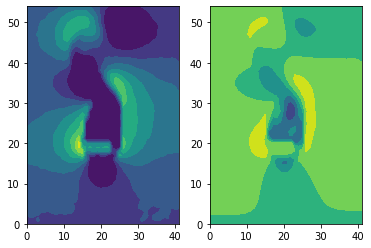

In [4]:
grid = x_val[250:251, :, :, :]
res = cae.predict(grid)

fig, ax = plt.subplots(1,2)
ax[0].contourf(res[0,:,:,0])
ax[1].contourf(grid[0, :, :, 0])

#### Prepare output to reconstruct to .vtu file 

In [5]:
snapshots = layer(snapshots)
res = cae.predict(snapshots)

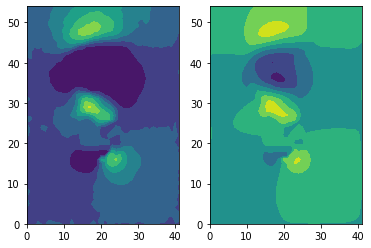

In [18]:
fig, ax = plt.subplots(1,2)
ax[0].contourf(res[92,:,:,1])
ax[1].contourf(snapshots[92, :, :, 1])

In [11]:
# Reshape to how reconstruction legacy code wants it
reconstruction = res.reshape((4, 2000, 55, 42, 2)).swapaxes(1, 4)
np.save("reconstruction.npy", reconstruction)

### Our dataset (221x42)

In [2]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_1_1000steps.npy")

input_shape = (221, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 1000)
snapshots = np.array(snapshots).reshape(1000, *input_shape)
print(snapshots.shape)

from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(snapshots, test_size=0.1)

(1000, 221, 42, 2)


In [3]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999)

encoder, decoder = build_agostini_encoder_decoder(input_shape, 10, initializer, info=True)

cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 221, 42, 16)       816       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 21, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 21, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 6, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 10752)             0

In [7]:
cae.train(x_train, 200, x_val, plot_loss=True, print_loss=True)

TypeError: train() got an unexpected keyword argument 'plot_loss'

# Adversarial Autoencoder

In [2]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

input_shape = (55, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 2000)
snapshots = np.array(snapshots).reshape(8000, *input_shape)
snapshots.shape

from sklearn.model_selection import train_test_split

# Data normalization
layer = preprocessing.Normalization()
layer.adapt(snapshots)

x_train, x_val = train_test_split(snapshots, test_size=0.1)

In [3]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)

encoder, decoder = build_wider_omata_encoder_decoder(input_shape, 10, initializer, info=True)
discriminator = build_custom_discriminator(10, initializer, info=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 42, 16)        816       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 21, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2688)              0

### Separate losses

In [4]:
aae = AAE(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)
aae.train(x_train, 100, val_data=x_val)

KeyboardInterrupt: 

### Combined losses

In [4]:
aae = AAE_combined_loss(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)
aae.train(snapshots, 100, val_data=x_val)

4/4 [==============================] - 0s 45ms/step - loss: 0.0036 - sequential_1_loss: 8.3624e-04 - sequential_2_loss: 2.7681


4/4 [==============================] - 0s 6ms/step - loss: 0.0994 - accuracy: 1.0000


4/4 [==============================] - 0s 14ms/step - loss: 0.0013 - sequential_1_loss: 2.4902e-04 - sequential_2_loss: 1.0431


KeyboardInterrupt: 

# SVD Autoencoder

In [5]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

# Data normalization
layer = preprocessing.Normalization(axis=None)
layer.adapt(snapshots_grids)

snapshots_grids = snapshots_grids.swapaxes(0,2)

In [6]:
x_train, x_val = train_test_split(snapshots_grids, test_size=0.1 )
x_train = layer(x_train).numpy().swapaxes(0, 2)
x_val = layer(x_val).numpy().swapaxes(0, 2)

In [4]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0006, beta_1=0.9, beta_2=0.999)

dense_encoder = build_slimmer_dense_encoder(10, initializer, info=False,  dropout=0.6)
dense_decoder = build_slimmer_dense_decoder(30, 10, initializer, info=False,  dropout=0.6)

svdae = SVDAE(dense_encoder, dense_decoder, optimizer)
svdae.compile(30)

In [ ]:
svdae.train(x_train, 50, val_data=x_val)

In [6]:
original = snapshots_grids[2, :, 200]

result = svdae.predict_single(original)
result = np.expand_dims(result,(0,2))
input_shape = (55, 42, 2)
result = convert_2d(result, input_shape, 1)


original = np.expand_dims(original,(0,2))
input_shape = (55, 42, 2)
original = convert_2d(original, input_shape, 1)


fig, ax = plt.subplots(1,2)
ax[0].contourf(result[0][0, :, :, 0])
ax[1].contourf(original[0][0, :, :, 0])

IndexError: index 200 is out of bounds for axis 2 with size 4

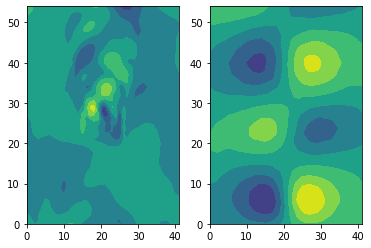

In [28]:
original = x_val[2, :, 30]

result = svdae.predict_single(original)
result = np.expand_dims(result,(0,2))
input_shape = (55, 42, 2)
result = convert_2d(result, input_shape, 1)


original = np.expand_dims(original,(0,2))
input_shape = (55, 42, 2)
original = convert_2d(original, input_shape, 1)


fig, ax = plt.subplots(1,2)
ax[0].contourf(result[0][0, :, :, 0])
ax[1].contourf(original[0][0, :, :, 0])